In [1]:
#установим связь с гугл диском
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [3]:
!ls /content/gdrive/MyDrive/Reinforcement_learning/

buffer.pkl	    experience.csv		       modelRL_v2.pth
CartPole_DQL.ipynb  experienceRL.csv		       p_modelRL_3hours_double_tout_v1_TD3.pt
chapter-03.ipynb    FrozenLake_DQL.ipynb	       p_modelRL_3hours_double_tout_v4.pt
chapter-04.ipynb    HeatRL_DDPG.ipynb		       p_modelRL_3hours_double_tout_v4.pth
chapter-05.ipynb    HeatRL_SAC.ipynb		       p_modelRL_M63.pt
chapter-06.ipynb    HeatRL_TD3.ipynb		       p_modelRL_M63_v2.pt
chapter-07.ipynb    modelRL_3hours_double_target.pt    p_modelRL_M63_v3.pt
chapter-08.ipynb    modelRL_3hours_double_target.pth   transit_modelRL_3hours_double_tout_v4.pt
chapter-09.ipynb    modelRL_3hours_double_tout_v1.pth  v_modelRL_3hours_double_tout_v1_TD3.pt
chapter-10.ipynb    modelRL_3hours_double_tout_v2.pth  v_modelRL_3hours_double_tout_v4.pt
chapter-11.ipynb    modelRL_3hours_double_tout_v3.pth  v_modelRL_3hours_double_tout_v4.pth
chapter-12.ipynb    modelRL_3hours.pth		       v_modelRL_M63.pt
data1.csv	    modelRL_3hours_v2.pth	       v_modelRL_M63_v2.p

In [4]:
model_path = '/content/gdrive/MyDrive/Reinforcement_learning/'

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal

import numpy as np
import pandas as pd
from itertools import count
from datetime import datetime
import time
import tempfile
import random
import gc
import os
import glob
import re
import math
import pickle

import matplotlib.pyplot as plt

from tqdm import tqdm
from tabulate import tabulate

SEEDS = (12, 34, 56, 78, 90)

%matplotlib inline

In [6]:
torch.__version__

'2.2.1+cu121'

In [7]:
torch.cuda.is_available()

False

In [8]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

# Создание массива соответствия tпод и Q

In [ ]:
#функция зависимости температуры подаваемого теплоносителя и тепловой нагрузки
def t_heat(Q):
  return 56 + 9.2*math.log(Q, 2.7) + Q + Q**2.1
  #return 12*Q +42.2

In [ ]:
t_list = [0.11263, 0.7, 1.7, 2.5, 2.8, 3.3, 4.1]
t_fact = [44.2, 53, 67.4, 70.2, 73.2, 75.6, 92.1]
for indx, t in enumerate(t_list):
  print(round(t_heat(t),1), '....', t_fact[indx], '.....', round(t_heat(t) - t_fact[indx],1))

35.9 .... 44.2 ..... -8.3
53.9 .... 53 ..... 0.9
65.7 .... 67.4 ..... -1.7
73.8 .... 70.2 ..... 3.6
77.0 .... 73.2 ..... 3.8
82.6 .... 75.6 ..... 7.0
92.5 .... 92.1 ..... 0.4


In [ ]:
#функция зависимости температуры подаваемого теплоносителя и тепловой нагрузки (Михалковская, 63)
def t_heat(Q):
  #return 40 + 12*math.log(Q, 2.7) + 25*Q + 25*Q**2.1
  #return 45 + 10*math.log(Q, 1.8) + 37*Q**0.05 + 35*Q
  return 120*Q +33

In [ ]:
t_list = [0.11263, 0.1408, 0.1883, 0.2367]
t_fact = [44.2, 49.0, 55.0, 64.0]
for indx, q in enumerate(t_list):
  print(round(t_heat(q),1), '....', t_fact[indx], '.....', round(t_heat(q) - t_fact[indx],1))

46.5 .... 44.2 ..... 2.3
49.9 .... 49.0 ..... 0.9
55.6 .... 55.0 ..... 0.6
61.4 .... 64.0 ..... -2.6


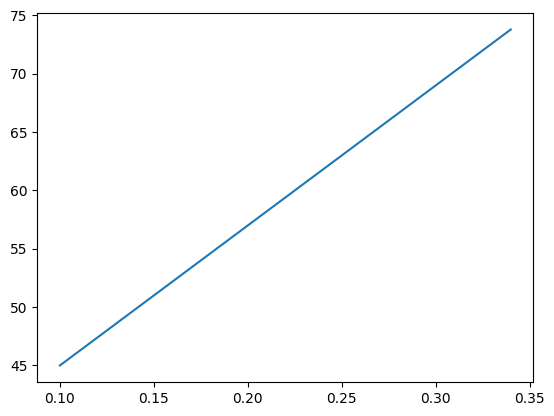

In [ ]:
t_list = []
q_list = []
for i in range(25):
  q = 0.1 + i*0.01
  q_list.append(q)
  t_list.append(t_heat(q))

plt.plot(q_list,t_list)

In [ ]:
#функция потери для нахождения Q по tпод методом градиентного спуска
def loss(t_target, Q):
  return abs(t_target - t_heat(Q))

In [ ]:
#градиент функции потери
#def grad_loss(Q):
#  return 9.2/(Q*math.log(1.6)) + 1.2/(Q**0.2)
def grad_loss(Q):
  return 10/(Q*math.log(1.8)) + 1.85/(Q**0.95) +35

In [ ]:
#задаем параметры начала списка температур, его конца и шага
start_temp = 40
end_temp = 90
step_temp = 0.1

In [ ]:
#создаем список из температур от начальной до конечной температур с определенным шагом
heat_temps = np.empty(shape=(int((end_temp - start_temp)/step_temp)), dtype=np.ndarray)
#heat_temps = [start_temp]
for step in range(int((end_temp - start_temp)/step_temp)):
  #heat_temps.append(round(heat_temps[-1] + step_temp, 1))
  heat_temps[step] = np.round(start_temp + step*step_temp,1)

In [ ]:
heat_temps.shape

(500,)

In [ ]:
#задаем скорость обучения для градиентного спуска
lr = 0.0001

In [ ]:
#создаем пустой массив размером (длина списка температур на 3 столбца), 3 столбца: tпод, Q, loss
t_Q_table = np.empty(shape=(int((end_temp - start_temp)/step_temp), 3), dtype=np.ndarray)

In [ ]:
#запускаем градиентный спуск для каждого шага списка температур и заполняем массив
#Q = 0.4
for idx, t in enumerate(tqdm(heat_temps)):
  Q = 0.2
  for step in count():
    Q = abs(Q - lr*grad_loss(Q))
    l = loss(t, Q)
    if l < 0.01 or step > 100000:
      t_Q_table[idx] = [t, round(Q,2), round(l,3)]
      break

100%|██████████| 500/500 [00:07<00:00, 63.31it/s]


In [ ]:
t_Q_table.shape

(500, 3)

In [ ]:
t_Q_table[:, 1]

array([0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.07, 0.07, 0.07,
       0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.08,
       0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08,
       0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.11,
       0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11,
       0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12,
       0.12, 0.12, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13,
       0.13, 0.13, 0.13, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14,
       0.14, 0.14, 0.14, 0.14, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15,
       0.15, 0.15, 0.15, 0.15, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16,
       0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.17, 0.17, 0.17, 0.17, 0.17,
       0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.18, 0.18, 0.18, 0.18,
       0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.

In [ ]:
Q = t_Q_table[230:240, 1]
Q

array([0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.26, 0.26, 0.26],
      dtype=object)

In [ ]:
for q in Q:
  print(round(t_heat(q),1))

63.0
63.0
63.0
63.0
63.0
63.0
63.0
64.2
64.2
64.2


# Модель

## Буфер опыта и вспомогательные функции

In [ ]:
#Глобальные переменные, доступные для всех моддулей
#характеристика здания (цех 15-1 УЗХМ)
#qV = 0.07
#Михалковской,63
qV = 0.007

# количество часов, необходимое зданию для остывания в e раз (2,71 раз)
gamma = 70

In [ ]:
#функция расчета температуры воздуха внутри помещения после изменения Q подачи
def next_temp(state, Q, t=3, q_V = qV, gamma = gamma):

  #коэффициент влияния погодных условий на скорость остывания здания,
  #зависящий от скорости ветра, его направления, влажности и облачности
  betta = 1 + (state[4] + state[5] + state[3]/5)/3

  #температуру снаружи посещения возьмем как среднюю между температурами в начале периода и в конце периода
  toutside = (state[1] + state[2])/2
  tinside = state[0]

  #формула взята из научной статьи и является приблизительной (только для начального обучения сети)
  t = toutside + Q/q_V + (tinside - toutside - Q/q_V)/(np.exp(t*betta/gamma))
  return t

In [ ]:
t_heat(0.15)

51.0

In [ ]:
next_temp([22.6, -9.0, -9.0, 2, 0.74, 0.9, 22, 22], 0.2367)

22.753824444989473

In [ ]:
experience_df = pd.read_csv(model_path + 'experienceRL.csv')[1600:]
experience_df = experience_df[experience_df.Theat >=45]
experience_df = experience_df[experience_df.Theat <85]

In [ ]:
delta_list = []
for i in range(len(experience_df)):
  test = list(experience_df.iloc[i].values[1:9])
  Theat = experience_df.iloc[i].values[9]
  idx = np.where(t_Q_table[:, 0] == Theat)[0][0]
  Qheat = t_Q_table[idx, 1]
  tnext = next_temp(test, Qheat)
  tnext_fact = experience_df.iloc[i].values[11]
  delta = abs(tnext_fact -tnext )
  delta_list.append(delta)
  #print(test, Theat, Qheat, tnext, tnext_fact, delta)

In [ ]:
len(delta_list), round(sum(delta_list)/len(delta_list),1), np.array(delta_list).std()

(1474, 1.1, 0.7156602296639268)

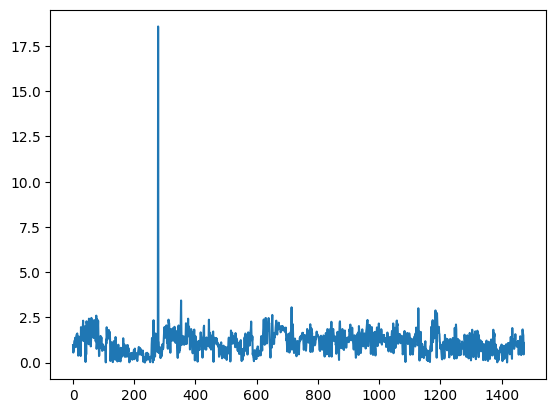

In [ ]:
plt.plot(range(len(delta_list)), delta_list)
plt.show()

In [ ]:
experience_df.loc[:, ['Ttarget_current', 'Ttarget_next', 'Ttarget_current_n', 'Ttarget_next_n']] = 17

In [ ]:
experience_df.sample(3)

,Date,Tinside,Toutside,Toutside2,W,Hd,Cl,Ttarget_current,Ttarget_next,Theat,Reward,Tinside_n,Toutside_n,Toutside_n2,W_n,Hd_n,Cl_n,Ttarget_current_n,Ttarget_next_n,weights
2128,11.12.2022 11:00,17.299999,-8.9,-8.2,2.0,0.51,1.0,17,17,66.5,-0.5,17.5,-8.2,-6.6,2.0,0.59,1.0,17,17,66
1897,11.11.2022 8:00,18.700001,1.3,1.9,2.0,0.87,1.0,17,17,60.3,-0.5,17.5,1.9,3.0,3.0,0.89,1.0,17,17,59
2028,28.11.2022 11:00,14.300000,-18.9,-14.8,1.0,0.75,0.2,17,17,79.9,-1.8,15.2,-14.8,-15.6,2.0,0.68,0.0,17,17,63


In [ ]:
#функция расчета награды (отпущеной тепловой энергии в текущем часу + штраф), action - tподачи
def reward(state, action, t_Q_table):
  idx = np.where(t_Q_table[:, 0] == np.round(action))[0][0]
  Qheat = t_Q_table[idx, 1]
  tnext = next_temp(state, Qheat)
  #with torch.no_grad():
  #  tnext = transit_func(state[:1] + [(state[1] + state[2])/2] + [action])
  #  tnext = tnext.item()

  t_target = state[7]

  penalty =abs(tnext-t_target)

  r = -penalty

  return round(r,2), Qheat, round(tnext,1)

In [ ]:
for t in [45,55,60,65,70,80]:
  print(reward([21, -3, 10, 5, 0.7, 0.8, 20, 22], t, t_Q_table))

(-1.24, 0.1, 20.8)
(-0.38, 0.18, 21.6)
(-0.05, 0.22, 22.1)
(-0.59, 0.27, 22.6)
(-1.02, 0.31, 23.0)
(-1.89, 0.39, 23.9)


In [ ]:
#класс стохастичного выбора действия и других параметров опыта (нар. температура, ветер, влажность, облачность)
class NormalNoiseStrategy():
    def __init__(self, bounds=(40,85), exploration_noise_ratio=0.3, temp_noise_ratio=2,
                        wind_noise_ratio = 0.5, humidity_noise_ratio = 0.1,
                        cloudiness_noise_ratio = 0.1):
        self.low, self.high = bounds

        self.exploration_noise_ratio = exploration_noise_ratio
        self.temp_noise_ratio = temp_noise_ratio
        self.wind_noise_ratio = wind_noise_ratio
        self.humidity_noise_ratio = humidity_noise_ratio
        self.cloudiness_noise_ratio = cloudiness_noise_ratio

    def select_action(self, model, state, max_exploration=False):
        if max_exploration:
            noise_scale = self.high
        else:
            noise_scale = self.exploration_noise_ratio * self.high

        with torch.no_grad():
          greedy_action = model(state).cpu().detach().data.numpy().squeeze()

        noise = np.random.normal(loc=0, scale=noise_scale, size=1)
        noisy_action = greedy_action + noise
        action = np.clip(noisy_action, self.low, self.high)

        return action

    def select_next_temps (self, state):
        noise_scale = self.temp_noise_ratio
        temp_noise1 = state[1] + np.random.normal(loc=0, scale=noise_scale, size=1)
        temp_noise2 = state[2] + np.random.normal(loc=0, scale=noise_scale, size=1)
        tnext1 = np.clip(temp_noise1, -10, 5)
        tnext2 = np.clip(temp_noise2, -10, 5)
        return tnext1, tnext2

    def select_next_wind (self, state):
        noise_scale = self.wind_noise_ratio
        wind_noise = state[3] + np.random.normal(loc=0, scale=noise_scale, size=1)
        Wnext = np.clip(wind_noise, 0, 25)
        return Wnext

    def select_next_humidity (self, state):
        noise_scale = self.humidity_noise_ratio
        humidity_noise = state[4] + np.random.normal(loc=0, scale=noise_scale, size=1)
        Hnext = np.clip(humidity_noise, 0.0, 1.0)
        return Hnext

    def select_next_cloudiness (self, state):
        noise_scale = self.cloudiness_noise_ratio
        cloudiness_noise = state[5] + np.random.normal(loc=0, scale=noise_scale, size=1)
        Cnext = np.clip(cloudiness_noise, 0.0, 1.0)
        return Cnext

    def select_period (self):
      day_period = random.choices(['day', 'night'])
      if day_period[0] == 'day':
        t_target = 22
      else:
        t_target = 20
      return t_target

In [ ]:
#выбор действия по детерминированной политике (жадный выбор)
class GreedyStrategy():
    def __init__(self, bounds):
        self.low, self.high = bounds

    def select_action(self, model, state):
        with torch.no_grad():
            greedy_action = model(state).cpu().detach().data.numpy().squeeze()

        action = np.clip(greedy_action, self.low, self.high)
        return action

In [ ]:
#класс буфера опыта
class ReplayBuffer():
    def __init__(self,
                 max_size=10000,
                 batch_size=32):
        self.ss_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.as_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.rs_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.ns_mem = np.empty(shape=(max_size), dtype=np.ndarray)

        self.max_size = max_size
        self.batch_size = batch_size
        self._idx = 0
        self.size = 0

    def store(self, sample):
        s, a, r, n = sample
        self.ss_mem[self._idx] = s
        self.as_mem[self._idx] = a
        self.rs_mem[self._idx] = r
        self.ns_mem[self._idx] = n

        self._idx += 1
        self._idx = self._idx % self.max_size

        self.size += 1
        self.size = min(self.size, self.max_size)

    def sample(self, step =0, batch_size=None):
        if batch_size == None:
            batch_size = self.batch_size

        #idxs = np.random.choice(
        #    self.size, batch_size, replace=True)
        idxs = np.random.choice(
            self.size, batch_size, replace=False)
        #idxs = [idx + step*batch_size for idx in range(batch_size)]
        experiences = np.vstack(self.ss_mem[idxs]), \
                      np.vstack(self.as_mem[idxs]), \
                      np.vstack(self.rs_mem[idxs]), \
                      np.vstack(self.ns_mem[idxs])
        return experiences

    def __len__(self):
        return self.size

## Создание смешанного файла опыта

In [ ]:
training_strategy = NormalNoiseStrategy((45,95), exploration_noise_ratio=0.15)

In [ ]:
bounds = (45,95)
p_model = FCDP(8, bounds, hidden_dims=(128,256,256))
p_model.to(DEVICE)
p_model.load_state_dict(torch.load(model_path + 'p_modelRL_3hours_double_tout_v4.pth', map_location=torch.device(DEVICE)))
p_model.train()

FCDP(
  (input_layer): Linear(in_features=8, out_features=128, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
  )
  (output_layer): Linear(in_features=256, out_features=1, bias=True)
)

In [ ]:
def interaction_step(state):
  action = np.round(training_strategy.select_action(p_model, state), 1)[0]

  t_target_n = training_strategy.select_period()

  r, Q, tnext_in = reward(state, action, t_Q_table)
  tnext_in = np.round(next_temp(state, Q), 1)
  tnext_out1, tnext_out2 = training_strategy.select_next_temps(state)
  tnext_out1 = np.round(tnext_out1, 1)[0]
  tnext_out2 = np.round(tnext_out2, 1)[0]
  Wnext = np.round(training_strategy.select_next_wind(state), 1)[0]
  Hnext = np.round(training_strategy.select_next_humidity(state), 1)[0]
  Cnext = np.round(training_strategy.select_next_cloudiness(state), 1)[0]
  ttarget_current = state[7]
  ttarget_next = t_target_n

  new_state = [np.round(tnext_in,1), tnext_out1, tnext_out2, Wnext, Hnext, Cnext, ttarget_current, ttarget_next]
  experience = state + [action] + [r] + new_state

  return experience

In [ ]:
state = [18, -1, -3, 5, 0.7, 0.7, 14, 14]

In [ ]:
date = '09.03.2024 20.00'

In [ ]:
data = []
for i in range(1600):
  experience = interaction_step(state)
  data.append([date] + experience)
  state = experience[-8:]

In [ ]:
df = pd.DataFrame(data, columns= experience_df.columns)

In [ ]:
df.sample(5)

,Date,Tinside,Toutside,Toutside2,W,Hd,Cl,Ttarget_current,Ttarget_next,Theat,Reward,Tinside_n,Toutside_n,Toutside_n2,W_n,Hd_n,Cl_n,Ttarget_current_n,Ttarget_next_n
1305,09.03.2024 20.00,15.8,-8.1,-4.6,2.4,0.6,0.5,14,14,45.2,-0.903823,14.9,-8.2,-4.3,3.6,0.7,0.5,14,17
958,09.03.2024 20.00,18.4,0.7,-0.9,2.5,1.0,0.9,17,17,45.0,-0.620455,17.6,0.1,1.2,2.2,1.0,1.0,17,14
1356,09.03.2024 20.00,15.5,-1.9,3.8,0.6,1.0,1.0,14,14,51.1,-1.229460,15.2,-4.4,2.8,0.9,0.9,1.0,14,14
1029,09.03.2024 20.00,16.2,-2.0,0.9,8.4,0.9,0.3,17,17,76.3,-0.612830,17.6,0.2,-3.8,7.7,0.7,0.3,17,14
553,09.03.2024 20.00,16.2,-6.1,-0.3,0.2,0.4,0.3,14,17,80.9,-0.398092,17.4,-6.4,-0.8,0.0,0.4,0.2,17,14


In [ ]:
df_concatinated = pd.concat([df, experience_df])

In [ ]:
weights = []
for i in range(len(df_concatinated)):
    weights.append(1 + int(100*i/len(df_concatinated)))

In [ ]:
weights = [1 + int(100*i/len(df_concatinated)) for i in range(len(df_concatinated))]

In [ ]:
df_concatinated.loc[:, 'weights'] = weights

In [ ]:
df_concatinated.head()

,Date,Tinside,Toutside,Toutside2,W,Hd,Cl,Ttarget_current,Ttarget_next,Theat,Reward,Tinside_n,Toutside_n,Toutside_n2,W_n,Hd_n,Cl_n,Ttarget_current_n,Ttarget_next_n,weights
0,09.03.2024 20.00,18.0,-1.0,-3.0,5.0,0.7,0.7,14,14,51.7,-3.342424,17.3,-1.4,-4.9,5.0,0.7,0.5,14,14,1
1,09.03.2024 20.00,17.3,-1.4,-4.9,5.0,0.7,0.5,14,14,56.1,-2.807538,16.8,-3.8,-5.8,5.2,0.7,0.5,14,17,1
2,09.03.2024 20.00,16.8,-3.8,-5.8,5.2,0.7,0.5,14,17,56.2,-0.779052,16.2,-2.4,-3.5,5.0,0.8,0.6,17,17,1
3,09.03.2024 20.00,16.2,-2.4,-3.5,5.0,0.8,0.6,17,17,60.4,-1.002045,16.0,-4.3,-3.1,4.9,0.7,0.7,17,14,1
4,09.03.2024 20.00,16.0,-4.3,-3.1,4.9,0.7,0.7,17,14,45.0,-1.134459,15.1,-2.8,-1.4,4.4,0.7,0.7,14,17,1


In [ ]:
df_concatinated.to_csv(model_path + 'experienceRL.csv', index=False)

In [ ]:
df_concatinated = pd.read_csv(model_path + 'experienceRL.csv')

In [ ]:
exp = df_concatinated.sample(5)

In [ ]:
exp

,Date,Tinside,Toutside,Toutside2,W,Hd,Cl,Ttarget_current,Ttarget_next,Theat,Reward,Tinside_n,Toutside_n,Toutside_n2,W_n,Hd_n,Cl_n,Ttarget_current_n,Ttarget_next_n,weights
3189,26.04.2023 2:00,22.600000,12.0,9.4,0.0,0.38,1.0,14,17,56.8,-5.000000,22.000000,9.4,11.2,1.0,0.49,1.0,17,17,99
2626,12.02.2023 8:00,16.299999,-10.6,-8.4,1.0,0.81,0.6,17,17,74.7,-0.400000,16.600000,-8.4,-4.6,1.0,0.71,0.6,17,17,82
2597,08.02.2023 17:00,17.400000,-10.7,-12.3,5.0,0.66,0.7,17,14,72.3,-3.200001,17.200001,-12.3,-12.1,5.0,0.74,1.0,14,14,81
1852,05.11.2022 17:00,16.200001,-2.1,-2.8,6.0,0.83,1.0,17,14,52.1,-2.100000,16.100000,-2.8,-3.0,4.0,0.83,0.9,14,14,58
2531,31.01.2023 5:00,18.299999,-5.7,-5.4,2.0,0.78,1.0,17,17,68.5,-1.400000,18.400000,-5.4,-5.0,1.0,0.73,1.0,17,17,79


In [ ]:
exp[exp.columns[9]].values.reshape(5,1)

array([[56.8],
       [74.7],
       [72.3],
       [52.1],
       [68.5]])

## Модели: политики, Q функции и DDPG обучения агента

In [ ]:
#Модель политики (выбора температуры подачи теплоносителя в определенном состоянии)
class FCDP(nn.Module):
    def __init__(self,
                 input_dim,
                 action_bounds = (40, 85),
                 hidden_dims=(32,32),
                 activation_fc=F.relu,
                 out_activation_fc=F.tanh):
        super(FCDP, self).__init__()
        self.activation_fc = activation_fc
        self.out_activation_fc = out_activation_fc
        self.env_min, self.env_max = action_bounds

        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], 1)

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)

        self.env_min = torch.tensor(self.env_min,
                                    device=self.device,
                                    dtype=torch.float32)

        self.env_max = torch.tensor(self.env_max,
                                    device=self.device,
                                    dtype=torch.float32)

        self.nn_min = self.out_activation_fc(
            torch.Tensor([float('-inf')])).to(self.device)
        self.nn_max = self.out_activation_fc(
            torch.Tensor([float('inf')])).to(self.device)
        self.rescale_fn = lambda x: (x - self.nn_min) * (self.env_max - self.env_min) / \
                                    (self.nn_max - self.nn_min) + self.env_min

    def _format(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x,
                             device=self.device,
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        return x

    def forward(self, state):
        x = self._format(state)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        x = self.output_layer(x)
        x = self.out_activation_fc(x)
        return self.rescale_fn(x)

In [ ]:
#Модель Q функции
class FCQV(nn.Module):
    def __init__(self,
                 input_dim,
                 output_dim,
                 hidden_dims=(32,32),
                 activation_fc=F.relu):
        super(FCQV, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            in_dim = hidden_dims[i]
            if i == 0:
                in_dim += output_dim
            hidden_layer = nn.Linear(in_dim, hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], 1)

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)

    def _format(self, state, action):
        x, u = state, action
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x,
                             device=self.device,
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        if not isinstance(u, torch.Tensor):
            u = torch.tensor(u,
                             device=self.device,
                             dtype=torch.float32)
            u = u.unsqueeze(0)
        return x, u

    def forward(self, state, action):
        x, u = self._format(state, action)
        x = self.activation_fc(self.input_layer(x))
        for i, hidden_layer in enumerate(self.hidden_layers):
            if i == 0:
                x = torch.cat((x, u), dim=1)
            x = self.activation_fc(hidden_layer(x))
        return self.output_layer(x)

    def load(self, experiences):
        states, actions, rewards, new_states = experiences
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        new_states = torch.from_numpy(new_states).float().to(self.device)
        return states, actions, rewards, new_states

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        #m.weight.data.fill_(0.01)
        m.bias.data.fill_(0.01)

In [ ]:
#Модель DDPG поиска оптимальной политики действия
class DDPG():
    def __init__(self,
                 replay_buffer_fn,
                 replay_buffer_data,
                 reward_fn,
                 next_temp_fn,
                 policy_model_fn,
                 policy_max_grad_norm,
                 policy_optimizer_fn,
                 policy_optimizer_lr,
                 policy_optim_scheduler,
                 value_model_fn,
                 value_max_grad_norm,
                 value_optimizer_fn,
                 value_optimizer_lr,
                 value_optim_scheduler,
                 training_strategy_fn,
                 n_warmup_batches,
                 update_target_every_steps,
                 tau,
                 weights_init_fn,
                 df):

        self.replay_buffer_fn = replay_buffer_fn
        self.replay_buffer_data = replay_buffer_data
        self.reward = reward_fn
        self.next_temp = next_temp_fn

        self.weights_init_fn = weights_init_fn

        self.policy_model_fn = policy_model_fn
        self.policy_max_grad_norm = policy_max_grad_norm
        self.policy_optimizer_fn = policy_optimizer_fn
        self.policy_optimizer_lr = policy_optimizer_lr
        self.policy_optim_scheduler = policy_optim_scheduler

        self.value_model_fn = value_model_fn
        self.value_max_grad_norm = value_max_grad_norm
        self.value_optimizer_fn = value_optimizer_fn
        self.value_optimizer_lr = value_optimizer_lr
        self.value_optim_scheduler = value_optim_scheduler

        self.training_strategy_fn = training_strategy_fn

        self.n_warmup_batches = n_warmup_batches
        self.update_target_every_steps = update_target_every_steps
        self.tau = tau

        self.df = df

    def optimize_model(self, experiences):
        states, actions, rewards, next_states = experiences
        batch_size = len(actions)

        argmax_a_q_sp = self.target_policy_model(next_states)
        max_a_q_sp = self.target_value_model(next_states, argmax_a_q_sp)
        target_q_sa = rewards + self.gamma * max_a_q_sp
        q_sa = self.online_value_model(states, actions)
        td_error = q_sa - target_q_sa.detach()
        value_loss = td_error.pow(2).mul(0.5).mean()
        self.value_optimizer.zero_grad()
        value_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.online_value_model.parameters(),
                                       self.value_max_grad_norm)
        self.value_optimizer.step()

        argmax_a_q_s = self.online_policy_model(states)
        max_a_q_s = self.online_value_model(states, argmax_a_q_s)

        policy_loss = -max_a_q_s.mean()
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.online_policy_model.parameters(),
                                       self.policy_max_grad_norm)
        self.policy_optimizer.step()

        return value_loss, policy_loss


    def interaction_step(self, state):
        min_samples = self.replay_buffer.batch_size * self.n_warmup_batches
        action = np.round(self.training_strategy.select_action(self.online_policy_model, state), 1)[0]

        t_target_n = self.training_strategy.select_period()

        #with torch.no_grad():
        r, Q, tnext_in = self.reward(state, action)
        tnext_in = np.round(self.next_temp(state, Q), 1)
        tnext_out1, tnext_out2 = self.training_strategy.select_next_temps(state)
        tnext_out1 = np.round(tnext_out1, 1)[0]
        tnext_out2 = np.round(tnext_out2, 1)[0]
        Wnext = np.round(self.training_strategy.select_next_wind(state), 1)[0]
        Hnext = np.round(self.training_strategy.select_next_humidity(state), 1)[0]
        Cnext = np.round(self.training_strategy.select_next_cloudiness(state), 1)[0]
        ttarget_current = state[7]
        ttarget_next = t_target_n

        new_state = [np.round(tnext_in,1), tnext_out1, tnext_out2, Wnext, Hnext, Cnext, ttarget_current, ttarget_next]
        experience = (state, action, r, new_state)
        self.replay_buffer.store(experience)

        #self.episode_reward[-1] += r
        self.episode_timestep[-1] += 1

        return new_state, action, r, Q

    def update_networks(self, tau=None):
        tau = self.tau if tau is None else tau
        for target, online in zip(self.target_value_model.parameters(),
                                  self.online_value_model.parameters()):
            target_ratio = (1.0 - tau) * target.data
            online_ratio = tau * online.data
            mixed_weights = target_ratio + online_ratio
            target.data.copy_(mixed_weights)

        for target, online in zip(self.target_policy_model.parameters(),
                                  self.online_policy_model.parameters()):
            target_ratio = (1.0 - tau) * target.data
            online_ratio = tau * online.data
            mixed_weights = target_ratio + online_ratio
            target.data.copy_(mixed_weights)

    def train(self, seed, gamma, max_episodes):

        self.seed = seed
        self.gamma = gamma

        torch.manual_seed(self.seed) ; np.random.seed(self.seed) ; random.seed(self.seed)

        nS, nA = 8, 1
        action_bounds = 40, 85
        self.episode_reward = []
        self.episode_timestep = []

        self.target_value_model = self.value_model_fn(nS, nA).apply(self.weights_init_fn)
        self.online_value_model = self.value_model_fn(nS, nA).apply(self.weights_init_fn)
        self.target_policy_model = self.policy_model_fn(nS, action_bounds).apply(self.weights_init_fn)
        self.online_policy_model = self.policy_model_fn(nS, action_bounds).apply(self.weights_init_fn)
        #self.target_value_model = self.value_model_fn
        #self.online_value_model = self.value_model_fn
        #self.target_policy_model = self.policy_model_fn
        #self.online_policy_model = self.policy_model_fn
        self.update_networks(tau=1.0)
        self.value_optimizer = self.value_optimizer_fn(self.online_value_model,
                                                       self.value_optimizer_lr)
        self.value_scheduler = self.value_optim_scheduler(self.value_optimizer)
        self.policy_optimizer = self.policy_optimizer_fn(self.online_policy_model,
                                                         self.policy_optimizer_lr)
        self.policy_scheduler = self.policy_optim_scheduler(self.policy_optimizer)

        self.replay_buffer = self.replay_buffer_fn()
        #self.replay_buffer = self.replay_buffer_fn
        self.training_strategy = training_strategy_fn(action_bounds)

        lrs = []
        policy_loss_list = []
        value_loss_list = []
        policy_loss = None
        value_loss = None
        mean_ep_reward = None
        self.episode_reward.append(0.0)
        self.episode_timestep.append(0.0)
        #state = [18, -1, -3, 5, 0.7, 0.7, 17, 17]

        bar = tqdm(range(max_episodes))
        for episode in bar:
            bar.set_description('Learning in progress')

            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)

            tin = random.uniform(14.0, 22.0)
            state = [tin, -1, -3, 5, 0.7, 0.7, 17, 17]

            for step in count():
                state, _, _, _ = self.interaction_step(state)

                min_samples = self.replay_buffer.batch_size * self.n_warmup_batches
                if len(self.replay_buffer) > min_samples:
                    experiences = self.replay_buffer.sample()
                    experiences = self.online_value_model.load(experiences)
                    value_loss, policy_loss = self.optimize_model(experiences)
                    lrs.append(self.policy_optimizer.param_groups[0]["lr"])

                if episode % 10 == 0 and episode <= 80:
                  self.policy_scheduler.step()
                  self.value_scheduler.step()
                if episode % 5 == 0 and policy_loss and value_loss:
                  policy_loss_list.append(policy_loss.item())
                  value_loss_list.append(value_loss.item())

                if np.sum(self.episode_timestep) % self.update_target_every_steps == 0:
                    self.update_networks()

                if step>200:
                    gc.collect()
                    break
            if policy_loss and value_loss:
              bar.set_postfix(p_loss = policy_loss.item(), v_loss = value_loss.item())
            else:
              bar.set_postfix(p_loss = policy_loss, v_loss = value_loss)
        #bar = tqdm(range(max_episodes))

        #for episode in bar:

        #    bar.set_description('Learning in progress')
        #    self.episode_timestep[-1] += 1

            #min_samples = self.replay_buffer.batch_size * self.n_warmup_batches
            #if episode <= 1600:
            #  state, _, _, _ = self.interaction_step(state)
            #if episode > 1600 and episode <= 3200:
            #  self.interaction_step_real(episode - 1600, experience_df)

            #if len(self.replay_buffer) > min_samples:
            #experiences = self.replay_buffer.sample()
       #     experiences = self.df.sample(64, weights='weights')

        ##   actions = experiences[experiences.columns[9]].values.reshape(64,1)
          #  rewards = experiences[experiences.columns[10]].values.reshape(64,1)
          #  next_states = experiences[experiences.columns[11:-1]].values

           # experiences = states, actions, rewards, next_states

            #experiences = self.online_value_model.load(experiences)
            #value_loss, policy_loss = self.optimize_model(experiences)
            #lrs.append(self.policy_optimizer.param_groups[0]["lr"])
            #if episode % 50 == 0:
            #  self.policy_scheduler.step()
            #  self.value_scheduler.step()

            #if episode % 50 == 0:
            #  policy_loss_list.append(policy_loss.item())
            #  value_loss_list.append(value_loss.item())

            #if np.sum(self.episode_timestep) % self.update_target_every_steps == 0:
            #    self.update_networks()

            #if policy_loss_list and value_loss_list:
            #  p_loss = round(policy_loss_list[-1],1)
            #  v_loss = round(value_loss_list[-1],1)

            #bar.set_postfix(p_loss = p_loss, v_loss = v_loss)

        plt.plot(range(len(policy_loss_list)),policy_loss_list)
        plt.show()
        plt.plot(range(len(value_loss_list)),value_loss_list)
        plt.show()
        plt.plot(range(len(lrs)),lrs)
        plt.show()

In [ ]:
bounds = (40,85)
p_model = FCDP(8, bounds, hidden_dims=(128,256,256))
p_model.to(DEVICE)
p_model.load_state_dict(torch.load(model_path + 'p_modelRL_M63_v2.pt', map_location=torch.device(DEVICE)))
#p_model.train()

<All keys matched successfully>

In [ ]:
#v_model = FCQV(8, 1, hidden_dims=(128,256,256))
#v_model.to(DEVICE)
#v_model.load_state_dict(torch.load(model_path + 'v_modelRL_3hours_double_tout_v4.pt', map_location=torch.device(DEVICE)))
#v_model.train()

<All keys matched successfully>

Learning in progress:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
Learning in progress: 100%|██████████| 100/100 [06:22<00:00,  3.83s/it, p_loss=4.7, v_loss=0.0264]


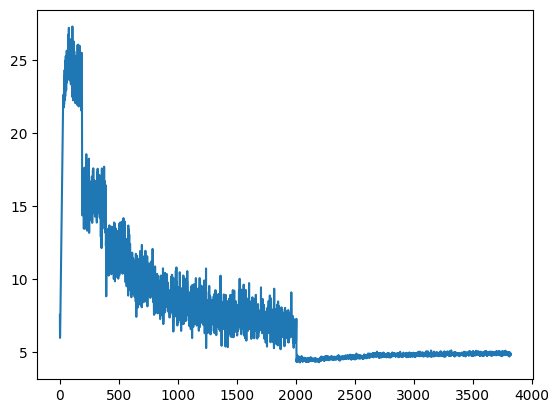

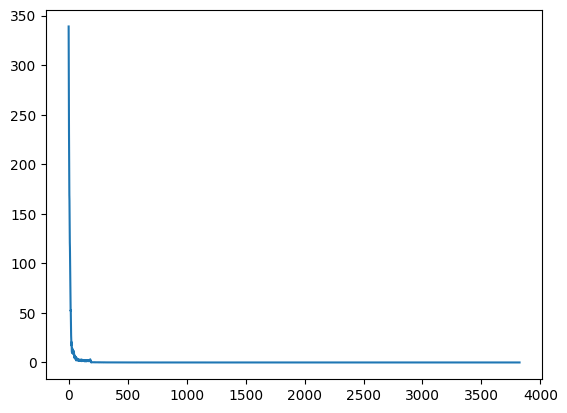

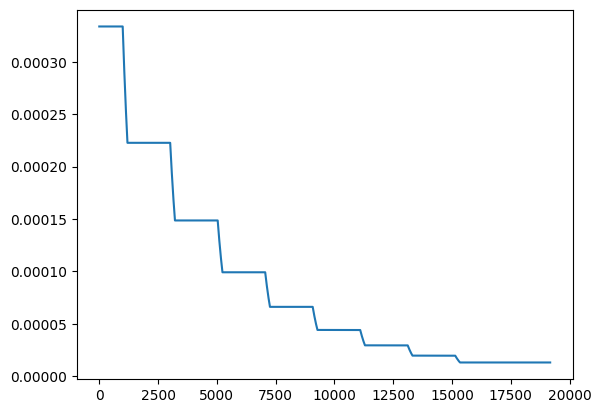

In [ ]:
for seed in SEEDS[:1]:

    max_episodes = 100
    gamma = 0.7

    policy_model_fn = lambda nS, bounds: FCDP(nS, bounds, hidden_dims=(128,256, 128, 64, 32))
    #policy_model_fn = p_model
    policy_max_grad_norm = float('inf')
    policy_optimizer_fn = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr, alpha=0.7)
    policy_optimizer_lr = 0.0005
    policy_optim_scheduler = lambda optimizer: optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.998)

    value_model_fn = lambda nS, nA: FCQV(nS, nA, hidden_dims=(128,256, 128, 64, 32))
    #value_model_fn = v_model
    value_max_grad_norm = float('inf')
    value_optimizer_fn = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr, alpha=0.7)
    value_optimizer_lr = 0.0005
    value_optim_scheduler = lambda optimizer: optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)

    training_strategy_fn = lambda bounds: NormalNoiseStrategy(bounds, exploration_noise_ratio=0.15)

    reward_fn = lambda state, action: reward(state, action, t_Q_table=t_Q_table)
    next_temp_fn = lambda state, Q: next_temp(state, Q)

    replay_buffer_fn = lambda: ReplayBuffer(max_size=10000, batch_size=128)
    with open(model_path + 'buffer.pkl', 'rb') as file:
      replay_buffer_data = pickle.load(file)

    n_warmup_batches = 8
    update_target_every_steps = 15
    tau = 0.001

    weights_init_fn = weights_init
    df = pd.read_csv(model_path + 'experienceRL.csv')
    df.loc[1601:, ['Ttarget_current', 'Ttarget_next', 'Ttarget_current_n', 'Ttarget_next_n']] = 17
    #df = pd.concat([df[:1600],df[1700:2300]])
    #df = df[:1600]

    agent = DDPG(replay_buffer_fn,
                 replay_buffer_data,
                 reward_fn,
                 next_temp_fn,
                 policy_model_fn,
                 policy_max_grad_norm,
                 policy_optimizer_fn,
                 policy_optimizer_lr,
                 policy_optim_scheduler,
                 value_model_fn,
                 value_max_grad_norm,
                 value_optimizer_fn,
                 value_optimizer_lr,
                 value_optim_scheduler,
                 training_strategy_fn,
                 n_warmup_batches,
                 update_target_every_steps,
                 tau,
                 weights_init_fn,
                 df)


    agent.train(seed, gamma, max_episodes)

In [ ]:
#with open(model_path + 'buffer.pkl', 'wb') as file:
#  pickle.dump(agent.replay_buffer.sample(batch_size = agent.replay_buffer.__len__()), file)

In [ ]:
eval_strat = GreedyStrategy(bounds=(40,85))

In [ ]:
model = agent.online_policy_model.eval()
#model = p_model.eval()
q_model = agent.online_value_model.eval()

In [ ]:
for idx, named_param in enumerate(p_model.named_parameters()):
  if idx < 6:
    named_param[1].requires_grad = False
  else:
    named_param[1].requires_grad = True

In [ ]:
for idx, named_param in enumerate(q_model.named_parameters()):
  if idx <= 7:
    named_param[1].requires_grad = False
  else:
    named_param[1].requires_grad = True

In [ ]:
for k,v in p_model.named_parameters():
    print('{}: {}'.format(k, v.requires_grad))

input_layer.weight: False
input_layer.bias: False
hidden_layers.0.weight: False
hidden_layers.0.bias: False
hidden_layers.1.weight: False
hidden_layers.1.bias: False
output_layer.weight: True
output_layer.bias: True


In [ ]:
params = [p for p in p_model.parameters()]

In [ ]:
params[6][0].size()

torch.Size([256])

In [ ]:
torch.save(agent.online_policy_model.state_dict(), model_path + 'p_modelRL_M63_v3.pt')
torch.save(agent.online_value_model.state_dict(), model_path + 'v_modelRL_M63_v3.pt')

In [ ]:
data = np.empty(shape=(10,10), dtype=np.ndarray)

for i in range(10):
  with torch.no_grad():
    t = round(np.random.normal(loc=21, scale=2, size=1)[0], 1)
    tout1 = round(np.random.normal(loc=-3, scale=7, size=1)[0], 1)
    tout2 = round(np.random.normal(loc= -1, scale=7, size=1)[0], 1)
    w = round(np.random.normal(loc=5, scale=2, size=1)[0], 1)
    h = round(np.random.normal(loc=0.7, scale=0.1, size=1)[0], 1)
    c = round(np.random.normal(loc=0.7, scale=0.1, size=1)[0], 1)
    ttarget_current = random.choices([22,20])[0]
    ttarget_next = random.choices([22,20])[0]
    state = [t, tout1, tout2, w, h, c, ttarget_current, ttarget_next]

    action_model = eval_strat.select_action(model, state)

    idx = np.where(t_Q_table[:, 0] == np.round(action_model, 1))[0][0]
    Q = t_Q_table[idx, 1]
    tnext = next_temp(state, Q)

    data[i] = (np.round(action_model,1), state[0], state[1], state[2], state[3], state[4],
              state[5], state[6], state[7], np.round(tnext,1))

headers = ['Tпод', 'Tвн', 'Tнар1', 'Tнар2', 'W', 'Hd', 'Cl', 'Tcurrent', 'Target', 'Tвн_сл']
print(tabulate(data, headers=headers))

  Tпод    Tвн    Tнар1    Tнар2    W    Hd    Cl    Tcurrent    Target    Tвн_сл
------  -----  -------  -------  ---  ----  ----  ----------  --------  --------
  72.2   20.1     -6.9      2.1  8.9   0.8   0.6          20        22      22.2
  40     23.1     -5.1      2.8  2.5   0.5   0.7          22        20      22.1
  80.4   18.8    -17.5      0.5  4.8   0.7   0.8          22        20      21
  40     24.3     -2.6     -3.1  3.5   0.6   0.9          22        22      23
  40     21.5     -5.4      3.7  6.4   0.9   0.7          22        20      20.4
  84.9   19.5     -7.6     -6.4  4.5   0.8   0.7          22        22      22.1
  61     21.5     -5.2     -6.6  6     0.7   0.7          22        22      21.9
  40     23.5     -5.4     -5    7     0.8   0.7          20        20      21.9
  57.5   21.6     -3.4     -0.8  5.8   0.8   0.7          22        22      22
  40     22.8      3.9      4.9  4.7   0.7   0.7          22        20      22.1


In [ ]:
data = np.empty(shape=(10,12), dtype=np.ndarray)

for i in range(10):
  with torch.no_grad():
    t = round(np.random.normal(loc=14, scale=2, size=1)[0], 1)
    tout1 = round(np.random.normal(loc=-3, scale=7, size=1)[0], 1)
    tout2 = round(np.random.normal(loc= -1, scale=7, size=1)[0], 1)
    w = round(np.random.normal(loc=5, scale=2, size=1)[0], 1)
    h = round(np.random.normal(loc=0.7, scale=0.1, size=1)[0], 1)
    c = round(np.random.normal(loc=0.7, scale=0.1, size=1)[0], 1)
    ttarget_current = random.choices([17,14])[0]
    ttarget_next = random.choices([17,14])[0]
    #state = [t, tout1, tout2, w, h, c, ttarget_current, ttarget_next]
    #sample = buffer.sample(step=random.randint(100, 1500), batch_size=1)
    #sample = df.sample(1)
    sample = df.iloc[1700:3000].sample(1)
    state = sample[sample.columns[1:9]].values[0]
    action_fact = sample[sample.columns[9]].values

    #state = sample[0][0]
    #action_fact = sample[1][0]
    #action_model = eval_strat.select_action(p_model, state)
    action_model = eval_strat.select_action(model, state)
    #q = q_model(state, [action])

    idx = np.where(t_Q_table[:, 0] == np.round(action_model, 1))[0][0]
    Q = t_Q_table[idx, 1]
    tnext = next_temp(state, Q)
    #_,_, tnext = reward(list(state), action_model, t_Q_table=t_Q_table, transit_func=transit_func)
    tnext_fact = sample[sample.columns[11]].values

    #data[i] = np.round(action,1), t, tout1, tout2, w, h, c, ttarget_current, ttarget_next, np.round(tnext,1), np.round(q.item(),1)
    data[i] = (np.round(action_model,1), action_fact, state[0], state[1], state[2], state[3], state[4],
              state[5], state[6], state[7], np.round(tnext,1), tnext_fact)#, np.round(q.item(),1)

headers = ['Tпод', 'Tпод_факт', 'Tвн', 'Tнар1', 'Tнар2', 'W', 'Hd', 'Cl', 'Tcurrent', 'Target', 'Tвн_сл', 'Tвн_сл_факт']#, 'Qf']
print(tabulate(data, headers=headers))

  Tпод    Tпод_факт    Tвн    Tнар1    Tнар2    W    Hd    Cl    Tcurrent    Target    Tвн_сл    Tвн_сл_факт
------  -----------  -----  -------  -------  ---  ----  ----  ----------  --------  --------  -------------
  48           71.3   17.5    -10.1    -13      3  0.74   1            17        17      16.6           16.8
  52           65.6   16.9     -2       -3.4    3  0.72   0.9          17        17      17.1           16.9
  85           80.4   14.3    -20.7    -20      2  0.77   0.6          17        17      16.1           14.2
  40           67.5   18.6     -5.8     -5.5    3  0.83   1            17        17      17.4           18.5
  55.7         73     16.8     -6.6     -6.8    6  0.35   0.9          17        17      17.1           16.9
  40           54.2   17.9      5.7      2.4    3  0.23   0            17        17      17.6           17.7
  85           80.5   15.2    -15.6    -14.4    5  0.48   0.9          17        17      17.5           15.4
  57.8         61.9

In [ ]:
data_df = pd.read_csv(model_path + 'data.csv', sep=';')

In [ ]:
data_df_reversed = data_df.iloc[::-1]

In [ ]:
data_df_reversed

,T,W,Hd,Cl,Target
102,-5.3,1,0.93,0.7,14
101,-5.5,2,0.91,1.0,14
100,-4.9,2,0.89,0.9,17
99,-5.8,2,0.85,0.9,17
98,-4.7,2,0.84,0.9,17
...,...,...,...,...,...
4,-9.2,2,0.61,0.9,17
3,-8.5,2,0.68,1.0,17
2,-6.1,1,0.82,1.0,17
1,-7.6,5,0.80,1.0,17


In [ ]:
data_numpy = data_df_reversed.values

In [ ]:
data_numpy.shape

(103, 5)

In [ ]:
t = 20

data = np.empty(shape=(103,9), dtype=np.ndarray)

for i in range(101):
  with torch.no_grad():
    tout1 = float(data_numpy[i][0])
    tout2 = float(data_numpy[i+1][0])
    w = float(data_numpy[i][1])
    h = float(data_numpy[i][2])
    c = float(data_numpy[i][3])
    ttarget_current = float(data_numpy[i-1][4])
    target_next = float(data_numpy[i][4])
    state = [t,tout1, tout2,w,h,c, ttarget_current, target_next]
    action = eval_strat.select_action(model, state)
    #q = q_model(state, [action])

    idx = np.where(t_Q_table[:, 0] == np.round(action, 1))[0][0]
    Q = t_Q_table[idx, 1]
    tnext = next_temp(state, Q)

    data[i] = np.round(action,1), t, tout1, tout2, w, h, c, target_next, np.round(tnext,1) #np.round(q.item(),1)
    t = tnext

headers = ['Tпод', 'Tвн', 'Tнар1', 'Tнар2', 'W', 'Hd', 'Cl', 'Target', 'Tвн_сл'] #'Qf']
print(tabulate(data, headers=headers))

  Tпод      Tвн    Tнар1    Tнар2    W    Hd    Cl    Target    Tвн_сл
------  -------  -------  -------  ---  ----  ----  --------  --------
  40    20          -5.3     -5.5    1  0.93   0.7        14      18.9
  40    18.878      -5.5     -4.9    2  0.91   1          14      17.7
  42.3  17.7452     -4.9     -5.8    2  0.89   0.9        17      16.9
  54.8  16.9115     -5.8     -4.7    2  0.85   0.9        17      17.2
  51.8  17.1635     -4.7     -5.4    2  0.84   0.9        17      17.2
  52    17.2091     -5.4     -6.8    1  0.84   0.9        17      17.2
  40    17.1783     -6.8     -7.1    1  0.85   0.9        14      16.1
  40    16.1162     -7.1     -7.4    2  0.88   0.7        14      15.1
  40    15.1002     -7.4     -7.7    2  0.88   0.7        14      14.1
  51.9  14.1334     -7.7     -7.3    2  0.91   0.1        14      14.2
  85    14.2081     -7.3     -7.3    3  0.88   0.9        17      17.2
  54    17.1613     -7.3     -6.5    3  0.88   1          17      17.2
  53.1

In [ ]:
model = agent.online_policy_model

In [ ]:
list1 = [(name, params) for name, params in model.named_parameters()]
list2 = [(name, params) for name, params in p_model.named_parameters()]

In [ ]:
len(list1), len(list2)

(8, 8)

In [ ]:
for i in range(8):
  print((list1[i][1] - list2[i][1]).sum())

tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)


In [ ]:
list1[0]

('input_layer.weight',
 Parameter containing:
 tensor([[-0.2866,  0.0470, -0.0605,  ..., -0.3885,  0.1558,  0.0078],
         [ 0.2592,  0.0381, -0.1340,  ..., -0.0768, -0.1757, -0.1658],
         [ 0.2621, -0.0356,  0.2739,  ..., -0.1941,  0.0316,  0.0097],
         ...,
         [-0.1936,  0.0392, -0.2261,  ..., -0.1099, -0.0303,  0.1467],
         [-0.0829, -0.0125, -0.1384,  ..., -0.1934, -0.2069,  0.0036],
         [-0.0045, -0.2291,  0.0028,  ..., -0.0539, -0.2439, -0.1752]],
        requires_grad=True))

In [ ]:
for m_params, p_params in zip(model.named_parameters(), p_model.named_parameters()):
    if m_params[1].requires_grad:
        print(m_params[1] == p_params[1])

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])
tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, Tr

In [ ]:
b = 'a'

In [ ]:
byte = b.encode('utf-8')

In [ ]:
byte[0]

97

In [ ]:
b'0'.decode('utf-8')

'0'

In [9]:
!pip install pymodbus

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.4/185.4 kB 1.4 MB/s eta 0:00:00


In [14]:
import pymodbus
from pymodbus.client import ModbusTcpClient

In [15]:
print(f"pymodbus version: v{pymodbus.__version__}")

pymodbus version: v3.6.6


In [36]:
client = ModbusTcpClient(comm='tcp', host='http://217.113.115.104', port=502, timeout=20, retries=5)   # Create client object
client.connect()                           # connect to device, reconnect automatically
#assert client.connected
#client.write_coil(1, True, slave=1)        # set information in device
result = client.read_coils(2, 3, slave=1)  # get information from device
#print(result.bits[0])
#print(result.registers)                     # use information
client.close()

ERROR:pymodbus.logging:Connection to (http://217.113.115.104, 502) failed: [Errno -2] Name or service not known
ERROR:pymodbus.logging:Connection to (http://217.113.115.104, 502) failed: [Errno -2] Name or service not known


ConnectionException: Modbus Error: [Connection] Failed to connect[ModbusTcpClient http://217.113.115.104:502]